# Optiver Volatility Prediction-EDA

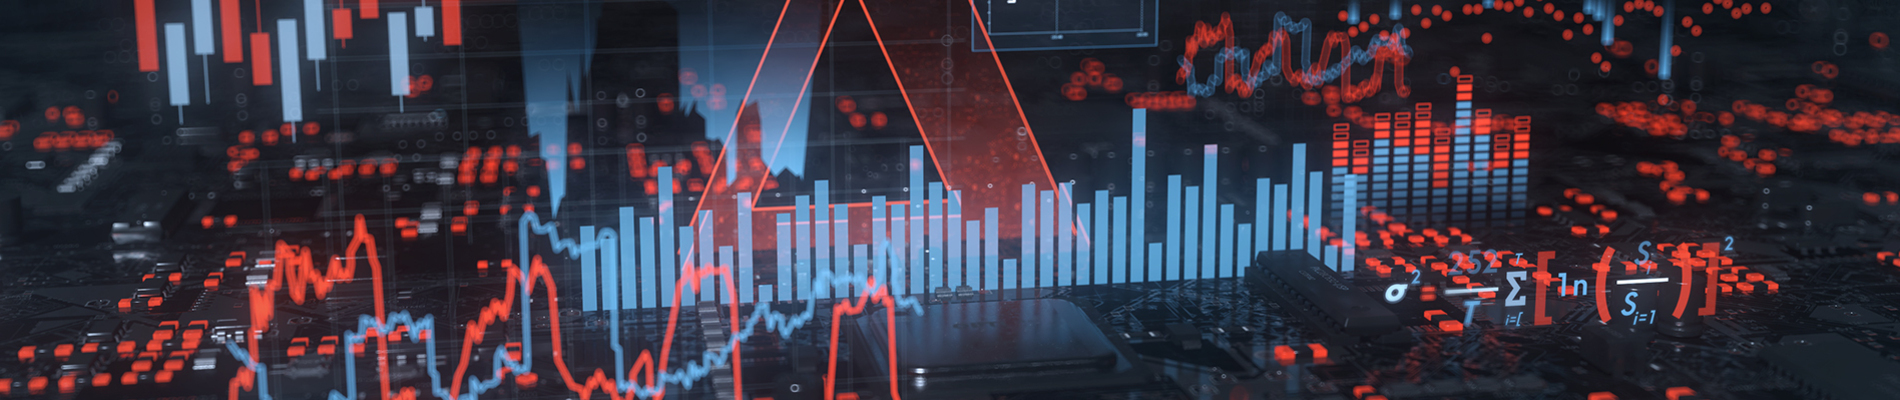

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# Importing libraries

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import glob
from tqdm import tqdm

import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib as mpl
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as gr_ob
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
print("train shape:",train.shape)
train.head(3)

* **stock_id** - ID code for the stock. Not all stock IDs exist in every time bucket.
* **time_id** - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
* **target** - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id.

In [ ]:
train.groupby(['stock_id']).size()

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train['target'], label = 'Target distribution')

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(train['time_id'], label = 'Time_id distribution')

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train, x="time_id", y="target")

# Order Book

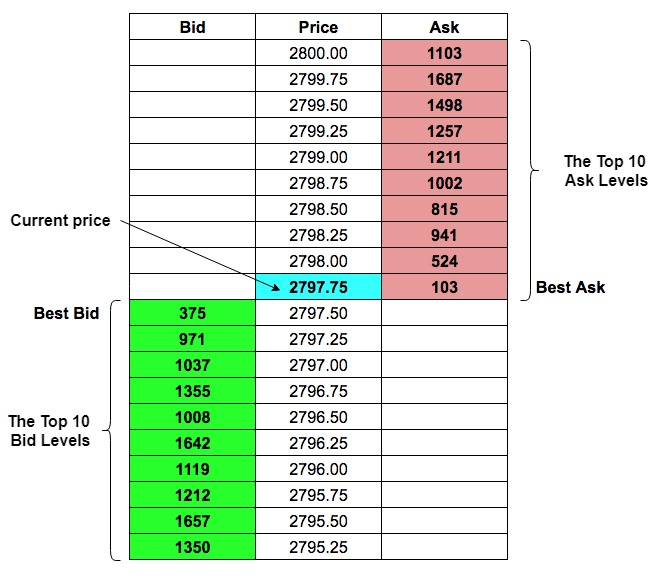
#### For more details about ORDER BOOK [here](https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data)

# Reading the data for stock id=1

* **trade_[train/test].parquet** A parquet file partitioned by stock_id. Contains data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

In [ ]:
stock_id = '1'
time_id=5

book = pd.read_parquet(f'../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id={stock_id}')
trade =  pd.read_parquet(f'../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id={stock_id}')
book = book[book['time_id']==time_id]
book.loc[:,'stock_id'] = stock_id

trade = trade[trade['time_id']==time_id]
trade.loc[:,'stock_id'] = stock_id


# book

In [ ]:
book.head(5)

* **seconds_in_bucket** - Number of seconds from the start of the bucket, always starting from 0.
* **bid_price[1/2]** - Normalized prices of the most/second most competitive buy level.
* **ask_price[1/2]** - Normalized prices of the most/second most competitive sell level.
* **bid_size[1/2]** - The number of shares on the most/second most competitive buy level.
* **ask_size[1/2]** - The number of shares on the most/second most competitive sell level.

In [ ]:
book.hist(figsize=(20,12))
plt.show()

In [ ]:
sns.pairplot(book[['seconds_in_bucket','ask_price1','ask_price2','ask_size1','ask_size2']],  diag_kind="hist",height=3)

In [ ]:
sns.pairplot(book[['seconds_in_bucket','bid_price1','bid_price2','bid_size1','bid_size2']],  diag_kind="hist",height=3)

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["ask_price1"], data = book)
sns.lineplot(x = book["seconds_in_bucket"], y =book["ask_price2"], data = book)
plt.legend(labels=['ask_price1', 'ask_price2'])
plt.show()

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["bid_price1"], data = book)
sns.lineplot(x = book["seconds_in_bucket"], y =book["bid_price2"], data = book)
plt.legend(labels=['bid_price1', 'bid_price2'])
plt.show()


In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["ask_size1"], data = book)
sns.lineplot(x = book["seconds_in_bucket"], y =book["ask_size2"], data = book)
plt.legend(labels=['ask_size1', 'ask_size2'])
plt.show()

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["bid_size1"], data = book)
sns.lineplot(x = book["seconds_in_bucket"], y =book["bid_size2"], data = book)
plt.legend(labels=['bid_size1', 'bid_size2'])
plt.show()

# Trade

In [ ]:
trade.head(5)

* **stock_id -** Same as above.
* **time_id-** Same as above.
* **seconds_in_bucket** - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
* **price** - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
* **size** - The sum number of shares traded.
* **order_count** - The number of unique trade orders taking place.

In [ ]:
trade.hist(figsize=(20,12))
plt.show()

In [ ]:
sns.pairplot(trade[['seconds_in_bucket','price','size']],  diag_kind="hist",height=3)

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = trade["seconds_in_bucket"], y =trade["size"], data = trade)
plt.legend(labels=['size'])
plt.show()

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = trade["seconds_in_bucket"], y =trade["price"], data = trade)
plt.legend(labels=['price'])
plt.show()

# Weighted Averaged Price WAP
* As realized volatility is a statistical measure of price changes on a given stock, to calculate the price change we first need to have a stock valuation at the fixed interval (1 second). We will use weighted averaged price, or WAP, of the order book data we provided.

* The formula of WAP can be written as below, which takes the top level price and volume information into account:
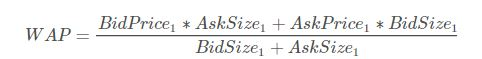

In [ ]:
book['wap'] = (book['bid_price1'] * book['ask_size1'] +book['ask_price1'] * book['bid_size1']) / (book['bid_size1']+ book['ask_size1'])
book.head(2)

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["wap"], data = book)
plt.legend(labels=['wap'])
plt.title("WAP of stock_id_1, time_id_5")
plt.show()

# Log returns
##### How can we compare the price of a stock between yesterday and today?
To compute the log return, we can simply take the logarithm of the ratio between two consecutive WAP.
The first row will have an empty return as the previous book update is unknown, therefore the empty return data point will be dropped.

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [ ]:
book.loc[:,'log_return'] = log_return(book['wap'])
book = book[~book['log_return'].isnull()]
book.head(2)

In [ ]:
plt.figure(figsize = (10,8)) 
sns.lineplot(x = book["seconds_in_bucket"], y =book["log_return"], data = book)
plt.legend(labels=['log_return'])
plt.title("log_return of stock_id_1, time_id_5")
plt.show()

# Realized volatility

* When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called volatility.
* In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:
* We will compute the log returns over all consecutive book updates and we define the realized volatility,  σ , as the squared root of the sum of squared log returns.


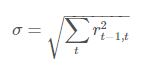

#### The realized vol of stock 1 in this feature bucket, will be:

In [ ]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))
realized_vol = realized_volatility(book['log_return'])
print(f'Realized volatility for stock_id 1 on time_id 5 is {realized_vol}')

# Function

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))


def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def calculate_wap(df):
    A = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    B = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    C = df['bid_size1'] + df['ask_size1'] + df['bid_size2']+ df['ask_size2']
    x = (A + B)/ C
    
    return x

def realized_volatility_per_time_id(file_path, prediction_column_name):
    df_book = pd.read_parquet(file_path)
    df_book['wap'] = calculate_wap(df_book)
    df_book['log_return'] = df_book.groupby(['time_id'])['wap'].apply(log_return)
    df_book = df_book[~df_book['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [ ]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                              realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [ ]:
list_train = glob.glob('../input/optiver-realized-volatility-prediction/book_train.parquet/*')

In [ ]:
list_train=list_train[0:5]

In [ ]:
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_train,prediction_column_name='pred')

In [ ]:
df_past_realized_train

In [ ]:
train

In [ ]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']],on = ['row_id'], how = 'left')

In [ ]:
df_joined

In [ ]:
df_joined = df_joined[~df_joined['pred'].isnull()]

In [ ]:
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

In [ ]:
list_order_book_file_test = glob.glob('../input/optiver-realized-volatility-prediction/book_test.parquet/*')

df_naive_pred_test = df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
                                                           prediction_column_name='target')
df_naive_pred_test.to_csv('submission.csv',index = False)

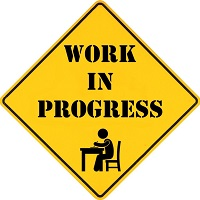

## References
1. https://www.kaggle.com/jiashenliu/introduction-to-financial-concepts-and-data
1. https://www.kaggle.com/sohommajumder21/optiver-competition-eda-predictions
1. https://www.kaggle.com/piantic/starter-optiver-quick-eda-automl-wip
1. https://www.kaggle.com/sohommajumder21/optiver-competition-eda-predictions
1. https://www.kaggle.com/konradb/we-need-to-go-deeper-and-validate?scriptVersionId=66939690
1. https://www.kaggle.com/lucasmorin/realised-vol-weighted-regression-baseline
1. https://www.kaggle.com/shahmahdihasan/overly-simplified-ols-prediction?scriptVersionId=67473702